# Optional Lab: Model Evaluation and Selection

Quantifying a learning algorithm's performance and comparing different models are some of the common tasks when applying machine learning to real world applications. In this lab, you will practice doing these using the tips shared in class. Specifically, you will:

* split datasets into training, cross validation, and test sets
* evaluate regression and classification models
* add polynomial features to improve the performance of a linear regression model
* compare several neural network architectures

This lab will also help you become familiar with the code you'll see in this week's programming assignment. Let's begin!

## Imports and Lab Setup

First, you will import the packages needed for the tasks in this lab. We also included some commands to make the outputs later more readable by reducing verbosity and suppressing non-critical warnings.

In [1]:
# for array computations and loading data
import numpy as np

# for building linear regression models and preparing data
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# for building and training neural networks
import tensorflow as tf

# custom functions
import utils

# reduce display precision on numpy arrays
np.set_printoptions(precision=2)

# suppress warnings
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

## Regression

First, you will be tasked to develop a model for a regression problem. You are given the dataset below consisting of 50 examples of an input feature `x` and its corresponding target `y`.

In [2]:
# Load the dataset from the text file
data = np.loadtxt('./data/data_w3_ex1.csv', delimiter=',')

# Split the inputs and outputs into separate arrays
x = data[:,0]
y = data[:,1]

# Convert 1-D arrays into 2-D because the commands later will require it
x = np.expand_dims(x, axis=1)
y = np.expand_dims(y, axis=1)

print(f"the shape of the inputs x is: {x.shape}")
print(f"the shape of the targets y is: {y.shape}")

the shape of the inputs x is: (50, 1)
the shape of the targets y is: (50, 1)


You can plot the dataset to get an idea of how the target behaves with respect to the input. In case you want to inspect the code, you can find the `plot_dataset()` function in the `utils.py` file outside this notebook.

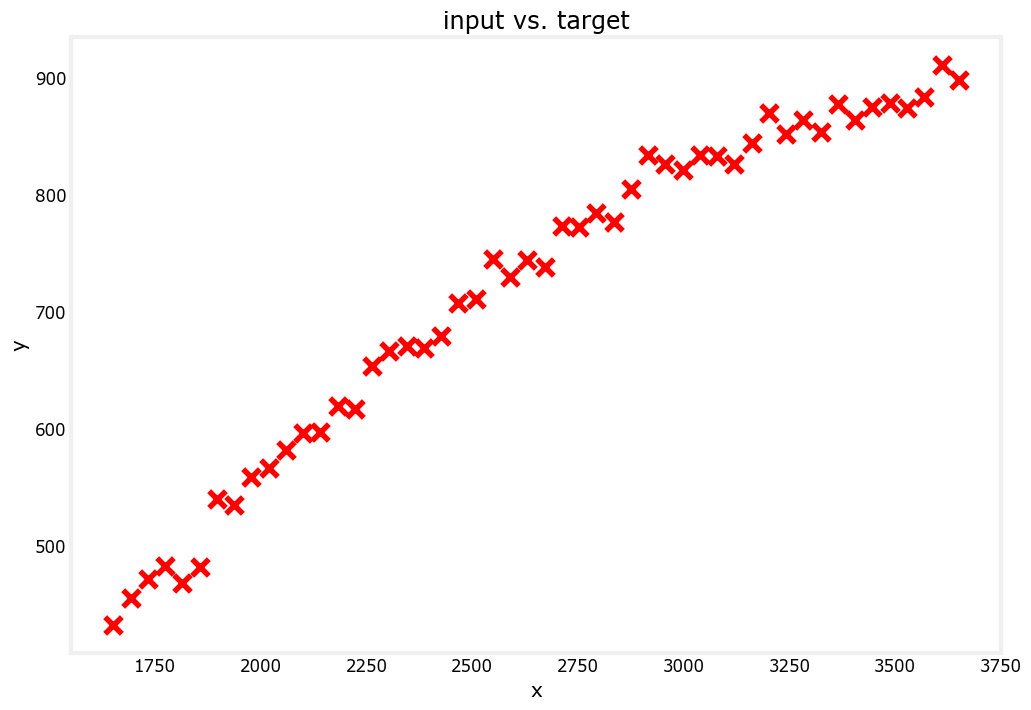

In [3]:
# Plot the entire dataset
utils.plot_dataset(x=x, y=y, title="input vs. target")

## Split the dataset into training, cross validation, and test sets

In previous labs, you might have used the entire dataset to train your models. In practice however, it is best to hold out a portion of your data to measure how well your model generalizes to new examples. This will let you know if the model has overfit to your training set.

As mentioned in the lecture, it is common to split your data into three parts:

* ***training set*** - used to train the model
* ***cross validation set (also called validation, development, or dev set)*** - used to evaluate the different model configurations you are choosing from. For example, you can use this to make a decision on what polynomial features to add to your dataset.
* ***test set*** - used to give a fair estimate of your chosen model's performance against new examples. This should not be used to make decisions while you are still developing the models.

Scikit-learn provides a [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function to split your data into the parts mentioned above. In the code cell below, you will split the entire dataset into 60% training, 20% cross validation, and 20% test.

In [ ]:
# Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables: x_ and y_.
x_train, x_, y_train, y_ = train_test_split(x, y, test_size=0.40, random_state=1)

# Split the 40% subset above into two: one half for cross validation and the other for the test set
x_cv, x_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.50, random_state=1)

# Delete temporary variables
del x_, y_

print(f"the shape of the training set (input) is: {x_train.shape}")
print(f"the shape of the training set (target) is: {y_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_cv.shape}\n")
print(f"the shape of the test set (input) is: {x_test.shape}")
print(f"the shape of the test set (target) is: {y_test.shape}")

You can plot the dataset again below to see which points were used as training, cross validation, or test data.

In [ ]:
utils.plot_train_cv_test(x_train, y_train, x_cv, y_cv, x_test, y_test, title="input vs. target")

## Fit a linear model

Now that you have split the data, one of the first things you can try is to fit a linear model. You will do that in the next sections below.

### Feature scaling

In the previous course of this specialization, you saw that it is usually a good idea to perform feature scaling to help your model converge faster. This is especially true if your input features have widely different ranges of values. Later in this lab, you will be adding polynomial terms so your input features will indeed have different ranges. For example, $x$ runs from around 1600 to 3600, while $x^2$ will run from 2.56 million to 12.96 million. 

You will only use $x$ for this first model but it's good to practice feature scaling now so you can apply it later. For that, you will use the [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) class from scikit-learn. This computes the z-score of your inputs. As a refresher, the z-score is given by the equation:

$$ z = \frac{x - \mu}{\sigma} $$

where $\mu$ is the mean of the feature values and $\sigma$ is the standard deviation. The code below shows how to prepare the training set using the said class. You can plot the results again to inspect if it still follows the same pattern as before. The new graph should have a reduced range of values for `x`.

In [ ]:
# Initialize the class
scaler_linear = StandardScaler()

# Compute the mean and standard deviation of the training set then transform it
X_train_scaled = scaler_linear.fit_transform(x_train)

print(f"Computed mean of the training set: {scaler_linear.mean_.squeeze():.2f}")
print(f"Computed standard deviation of the training set: {scaler_linear.scale_.squeeze():.2f}")

# Plot the results
utils.plot_dataset(x=X_train_scaled, y=y_train, title="scaled input vs. target")

### Train the model

Next, you will create and train a regression model. For this lab, you will use the [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) class but take note that there are other [linear regressors](https://scikit-learn.org/stable/modules/classes.html#classical-linear-regressors) which you can also use.

In [ ]:
# Initialize the class
linear_model = LinearRegression()

# Train the model
linear_model.fit(X_train_scaled, y_train )

### Evaluate the Model

To evaluate the performance of your model, you will measure the error for the training and cross validation sets. For the training error, recall the equation for calculating the mean squared error (MSE):

$$J_{train}(\vec{w}, b) = \frac{1}{2m_{train}}\left[\sum_{i=1}^{m_{train}}(f_{\vec{w},b}(\vec{x}_{train}^{(i)}) - y_{train}^{(i)})^2\right]$$

Scikit-learn also has a built-in [`mean_squared_error()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) function that you can use. Take note though that [as per the documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error), scikit-learn's implementation only divides by `m` and not `2*m`, where `m` is the number of examples. As mentioned in Course 1 of this Specialization (cost function lectures), dividing by `2m` is a convention we will follow but the calculations should still work whether or not you include it. Thus, to match the equation above, you can use the scikit-learn function then divide by 2 as shown below. We also included a for-loop implementation so you can check that it's equal. 

Another thing to take note: Since you trained the model on scaled values (i.e. using the z-score), you should also feed in the scaled training set instead of its raw values.

In [ ]:
# Feed the scaled training set and get the predictions
yhat = linear_model.predict(X_train_scaled)

# Use scikit-learn's utility function and divide by 2
print(f"training MSE (using sklearn function): {mean_squared_error(y_train, yhat) / 2}")

# for-loop implementation
total_squared_error = 0

for i in range(len(yhat)):
    squared_error_i  = (yhat[i] - y_train[i])**2
    total_squared_error += squared_error_i                                              

mse = total_squared_error / (2*len(yhat))

print(f"training MSE (for-loop implementation): {mse.squeeze()}")

You can then compute the MSE for the cross validation set with basically the same equation:

$$J_{cv}(\vec{w}, b) = \frac{1}{2m_{cv}}\left[\sum_{i=1}^{m_{cv}}(f_{\vec{w},b}(\vec{x}_{cv}^{(i)}) - y_{cv}^{(i)})^2\right]$$

As with the training set, you will also want to scale the cross validation set. An *important* thing to note when using the z-score is you have to use the mean and standard deviation of the **training set** when scaling the cross validation set. This is to ensure that your input features are transformed as expected by the model. One way to gain intuition is with this scenario:

* Say that your training set has an input feature equal to `500` which is scaled down to `0.5` using the z-score.
* After training, your model is able to accurately map this scaled input `x=0.5` to the target output `y=300`. 
* Now let's say that you deployed this model and one of your users fed it a sample equal to `500`. 
* If you get this input sample's z-score using any other values of the mean and standard deviation, then it might not be scaled to `0.5` and your model will most likely make a wrong prediction (i.e. not equal to `y=300`). 

You will scale the cross validation set below by using the same `StandardScaler` you used earlier but only calling its [`transform()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler.transform) method instead of [`fit_transform()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler.fit_transform).

In [ ]:
# Scale the cross validation set using the mean and standard deviation of the training set
X_cv_scaled = scaler_linear.transform(x_cv)

print(f"Mean used to scale the CV set: {scaler_linear.mean_.squeeze():.2f}")
print(f"Standard deviation used to scale the CV set: {scaler_linear.scale_.squeeze():.2f}")

# Feed the scaled cross validation set
yhat = linear_model.predict(X_cv_scaled)

# Use scikit-learn's utility function and divide by 2
print(f"Cross validation MSE: {mean_squared_error(y_cv, yhat) / 2}")

## Adding Polynomial Features

From the graphs earlier, you may have noticed that the target `y` rises more sharply at smaller values of `x` compared to higher ones. A straight line might not be the best choice because the target `y` seems to flatten out as `x` increases. Now that you have these values of the training and cross validation MSE from the linear model, you can try adding polynomial features to see if you can get a better performance. The code will mostly be the same but with a few extra preprocessing steps. Let's see that below.

### Create the additional features

First, you will generate the polynomial features from your training set. The code below demonstrates how to do this using the [`PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) class. It will create a new input feature which has the squared values of the input `x` (i.e. degree=2).

In [ ]:
# Instantiate the class to make polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)

# Compute the number of features and transform the training set
X_train_mapped = poly.fit_transform(x_train)

# Preview the first 5 elements of the new training set. Left column is `x` and right column is `x^2`
# Note: The `e+<number>` in the output denotes how many places the decimal point should 
# be moved. For example, `3.24e+03` is equal to `3240`
print(X_train_mapped[:5])

You will then scale the inputs as before to narrow down the range of values.

In [ ]:
# Instantiate the class
scaler_poly = StandardScaler()

# Compute the mean and standard deviation of the training set then transform it
X_train_mapped_scaled = scaler_poly.fit_transform(X_train_mapped)

# Preview the first 5 elements of the scaled training set.
print(X_train_mapped_scaled[:5])

You can then proceed to train the model. After that, you will measure the model's performance against the cross validation set. Like before, you should make sure to perform the same transformations as you did in the training set. You will add the same number of polynomial features then scale the range of values.

In [ ]:
# Initialize the class
model = LinearRegression()

# Train the model
model.fit(X_train_mapped_scaled, y_train )

# Compute the training MSE
yhat = model.predict(X_train_mapped_scaled)
print(f"Training MSE: {mean_squared_error(y_train, yhat) / 2}")

# Add the polynomial features to the cross validation set
X_cv_mapped = poly.transform(x_cv)

# Scale the cross validation set using the mean and standard deviation of the training set
X_cv_mapped_scaled = scaler_poly.transform(X_cv_mapped)

# Compute the cross validation MSE
yhat = model.predict(X_cv_mapped_scaled)
print(f"Cross validation MSE: {mean_squared_error(y_cv, yhat) / 2}")

You'll notice that the MSEs are significantly better for both the training and cross validation set when you added the 2nd order polynomial. You may want to introduce more polynomial terms and see which one gives the best performance. As shown in class, you can have 10 different models like this:

<img src='images/C2_W3_poly.png' width=50%>

You can create a loop that contains all the steps in the previous code cells. Here is one implementation that adds polynomial features up to degree=10. We'll plot it at the end to make it easier to compare the results for each model.

In [ ]:
# Initialize lists to save the errors, models, and feature transforms
train_mses = []
cv_mses = []
models = []
polys = []
scalers = []

# Loop over 10 times. Each adding one more degree of polynomial higher than the last.
for degree in range(1,11):
    
    # Add polynomial features to the training set
    poly = PolynomialFeatures(degree, include_bias=False)
    X_train_mapped = poly.fit_transform(x_train)
    polys.append(poly)
    
    # Scale the training set
    scaler_poly = StandardScaler()
    X_train_mapped_scaled = scaler_poly.fit_transform(X_train_mapped)
    scalers.append(scaler_poly)
    
    # Create and train the model
    model = LinearRegression()
    model.fit(X_train_mapped_scaled, y_train )
    models.append(model)
    
    # Compute the training MSE
    yhat = model.predict(X_train_mapped_scaled)
    train_mse = mean_squared_error(y_train, yhat) / 2
    train_mses.append(train_mse)
    
    # Add polynomial features and scale the cross validation set
    X_cv_mapped = poly.transform(x_cv)
    X_cv_mapped_scaled = scaler_poly.transform(X_cv_mapped)
    
    # Compute the cross validation MSE
    yhat = model.predict(X_cv_mapped_scaled)
    cv_mse = mean_squared_error(y_cv, yhat) / 2
    cv_mses.append(cv_mse)
    
# Plot the results
degrees=range(1,11)
utils.plot_train_cv_mses(degrees, train_mses, cv_mses, title="degree of polynomial vs. train and CV MSEs")

### Choosing the best model

When selecting a model, you want to choose one that performs well both on the training and cross validation set. It implies that it is able to learn the patterns from your training set without overfitting. If you used the defaults in this lab, you will notice a sharp drop in cross validation error from the models with degree=1 to degree=2. This is followed by a relatively flat line up to degree=5. After that, however, the cross validation error is generally getting worse as you add more polynomial features. Given these, you can decide to use the model with the lowest `cv_mse` as the one best suited for your application.

In [ ]:
# Get the model with the lowest CV MSE (add 1 because list indices start at 0)
# This also corresponds to the degree of the polynomial added
degree = np.argmin(cv_mses) + 1
print(f"Lowest CV MSE is found in the model with degree={degree}")

You can then publish the generalization error by computing the test set's MSE. As usual, you should transform this data the same way you did with the training and cross validation sets.

In [ ]:
# Add polynomial features to the test set
X_test_mapped = polys[degree-1].transform(x_test)

# Scale the test set
X_test_mapped_scaled = scalers[degree-1].transform(X_test_mapped)

# Compute the test MSE
yhat = models[degree-1].predict(X_test_mapped_scaled)
test_mse = mean_squared_error(y_test, yhat) / 2

print(f"Training MSE: {train_mses[degree-1]:.2f}")
print(f"Cross Validation MSE: {cv_mses[degree-1]:.2f}")
print(f"Test MSE: {test_mse:.2f}")

## Neural Networks

The same model selection process can also be used when choosing between different neural network architectures. In this section, you will create the models shown below and apply it to the same regression task above.

<img src='images/C2_W3_NN_Arch.png' width=40%>

### Prepare the Data

You will use the same training, cross validation, and test sets you generated in the previous section. From earlier lectures in this course, you may have known that neural networks can learn non-linear relationships so you can opt to skip adding polynomial features. The code is still included below in case you want to try later and see what effect it will have on your results. The default `degree` is set to `1` to indicate that it will just use `x_train`, `x_cv`, and `x_test` as is (i.e. without any additional polynomial features).

In [ ]:
# Add polynomial features
degree = 1
poly = PolynomialFeatures(degree, include_bias=False)
X_train_mapped = poly.fit_transform(x_train)
X_cv_mapped = poly.transform(x_cv)
X_test_mapped = poly.transform(x_test)

Next, you will scale the input features to help gradient descent converge faster. Again, notice that you are using the mean and standard deviation computed from the training set by just using `transform()` in the cross validation and test sets instead of `fit_transform()`.

In [ ]:
# Scale the features using the z-score
scaler = StandardScaler()
X_train_mapped_scaled = scaler.fit_transform(X_train_mapped)
X_cv_mapped_scaled = scaler.transform(X_cv_mapped)
X_test_mapped_scaled = scaler.transform(X_test_mapped)

### Build and train the models

You will then create the neural network architectures shown earlier. The code is provided in the `build_models()` function in the `utils.py` file in case you want to inspect or modify it. You will use that in the loop below then proceed to train the models. For each model, you will also record the training and cross validation errors.

In [ ]:
# Initialize lists that will contain the errors for each model
nn_train_mses = []
nn_cv_mses = []

# Build the models
nn_models = utils.build_models()

# Loop over the the models
for model in nn_models:
    
    # Setup the loss and optimizer
    model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    )

    print(f"Training {model.name}...")
    
    # Train the model
    model.fit(
        X_train_mapped_scaled, y_train,
        epochs=300,
        verbose=0
    )
    
    print("Done!\n")

    
    # Record the training MSEs
    yhat = model.predict(X_train_mapped_scaled)
    train_mse = mean_squared_error(y_train, yhat) / 2
    nn_train_mses.append(train_mse)
    
    # Record the cross validation MSEs 
    yhat = model.predict(X_cv_mapped_scaled)
    cv_mse = mean_squared_error(y_cv, yhat) / 2
    nn_cv_mses.append(cv_mse)

    
# print results
print("RESULTS:")
for model_num in range(len(nn_train_mses)):
    print(
        f"Model {model_num+1}: Training MSE: {nn_train_mses[model_num]:.2f}, " +
        f"CV MSE: {nn_cv_mses[model_num]:.2f}"
        )

From the recorded errors, you can decide which is the best model for your application. Look at the results above and see if you agree with the selected `model_num` below. Finally, you will compute the test error to estimate how well it generalizes to new examples.

In [ ]:
# Select the model with the lowest CV MSE
model_num = 3

# Compute the test MSE
yhat = nn_models[model_num-1].predict(X_test_mapped_scaled)
test_mse = mean_squared_error(y_test, yhat) / 2

print(f"Selected Model: {model_num}")
print(f"Training MSE: {nn_train_mses[model_num-1]:.2f}")
print(f"Cross Validation MSE: {nn_cv_mses[model_num-1]:.2f}")
print(f"Test MSE: {test_mse:.2f}")

## Classification

In this last part of the lab, you will practice model evaluation and selection on a classification task. The process will be similar, with the main difference being the computation of the errors. You will see that in the following sections.

### Load the Dataset

First, you will load a dataset for a binary classification task. It has 200 examples of two input features (`x1` and `x2`), and a target `y` of either `0` or `1`.

In [ ]:
# Load the dataset from a text file
data = np.loadtxt('./data/data_w3_ex2.csv', delimiter=',')

# Split the inputs and outputs into separate arrays
x_bc = data[:,:-1]
y_bc = data[:,-1]

# Convert y into 2-D because the commands later will require it (x is already 2-D)
y_bc = np.expand_dims(y_bc, axis=1)

print(f"the shape of the inputs x is: {x_bc.shape}")
print(f"the shape of the targets y is: {y_bc.shape}")

You can plot the dataset to examine how the examples are separated.

In [ ]:
utils.plot_bc_dataset(x=x_bc, y=y_bc, title="x1 vs. x2")

### Split and prepare the dataset

Next, you will generate the training, cross validation, and test sets. You will use the same 60/20/20 proportions as before. You will also scale the features as you did in the previous section.

In [ ]:
from sklearn.model_selection import train_test_split

# Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables.
x_bc_train, x_, y_bc_train, y_ = train_test_split(x_bc, y_bc, test_size=0.40, random_state=1)

# Split the 40% subset above into two: one half for cross validation and the other for the test set
x_bc_cv, x_bc_test, y_bc_cv, y_bc_test = train_test_split(x_, y_, test_size=0.50, random_state=1)

# Delete temporary variables
del x_, y_

print(f"the shape of the training set (input) is: {x_bc_train.shape}")
print(f"the shape of the training set (target) is: {y_bc_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_bc_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_bc_cv.shape}\n")
print(f"the shape of the test set (input) is: {x_bc_test.shape}")
print(f"the shape of the test set (target) is: {y_bc_test.shape}")

In [ ]:
# Scale the features

# Initialize the class
scaler_linear = StandardScaler()

# Compute the mean and standard deviation of the training set then transform it
x_bc_train_scaled = scaler_linear.fit_transform(x_bc_train)
x_bc_cv_scaled = scaler_linear.transform(x_bc_cv)
x_bc_test_scaled = scaler_linear.transform(x_bc_test)

### Evaluating the error for classification models

In the previous sections on regression models, you used the mean squared error to measure how well your model is doing. For classification, you can get a similar metric by getting the fraction of the data that the model has misclassified. For example, if your model made wrong predictions for 2 samples out of 5, then you will report an error of `40%` or `0.4`. The code below demonstrates this using a for-loop and also with Numpy's [`mean()`](https://numpy.org/doc/stable/reference/generated/numpy.mean.html) function. 

In [ ]:
# Sample model output
probabilities = np.array([0.2, 0.6, 0.7, 0.3, 0.8])

# Apply a threshold to the model output. If greater than 0.5, set to 1. Else 0.
predictions = np.where(probabilities >= 0.5, 1, 0)

# Ground truth labels
ground_truth = np.array([1, 1, 1, 1, 1])

# Initialize counter for misclassified data
misclassified = 0

# Get number of predictions
num_predictions = len(predictions)

# Loop over each prediction
for i in range(num_predictions):
    
    # Check if it matches the ground truth
    if predictions[i] != ground_truth[i]:
        
        # Add one to the counter if the prediction is wrong
        misclassified += 1

# Compute the fraction of the data that the model misclassified
fraction_error = misclassified/num_predictions

print(f"probabilities: {probabilities}")
print(f"predictions with threshold=0.5: {predictions}")
print(f"targets: {ground_truth}")
print(f"fraction of misclassified data (for-loop): {fraction_error}")
print(f"fraction of misclassified data (with np.mean()): {np.mean(predictions != ground_truth)}")

### Build and train the model

You will use the same neural network architectures in the previous section so you can call the `build_models()` function again to create new instances of these models. 

You will follow the recommended approach mentioned last week where you use a `linear` activation for the output layer (instead of `sigmoid`) then set `from_logits=True` when declaring the loss function of the model. You will use the [binary crossentropy loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) because this is a binary classification problem.

After training, you will use a [sigmoid function](https://www.tensorflow.org/api_docs/python/tf/math/sigmoid) to convert the model outputs into probabilities. From there, you can set a threshold and get the fraction of misclassified examples from the training and cross validation sets.

You can see all these in the code cell below.

In [ ]:
# Initialize lists that will contain the errors for each model
nn_train_error = []
nn_cv_error = []

# Build the models
models_bc = utils.build_models()

# Loop over each model
for model in models_bc:
    
    # Setup the loss and optimizer
    model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    )

    print(f"Training {model.name}...")

    # Train the model
    model.fit(
        x_bc_train_scaled, y_bc_train,
        epochs=200,
        verbose=0
    )
    
    print("Done!\n")
    
    # Set the threshold for classification
    threshold = 0.5
    
    # Record the fraction of misclassified examples for the training set
    yhat = model.predict(x_bc_train_scaled)
    yhat = tf.math.sigmoid(yhat)
    yhat = np.where(yhat >= threshold, 1, 0)
    train_error = np.mean(yhat != y_bc_train)
    nn_train_error.append(train_error)

    # Record the fraction of misclassified examples for the cross validation set
    yhat = model.predict(x_bc_cv_scaled)
    yhat = tf.math.sigmoid(yhat)
    yhat = np.where(yhat >= threshold, 1, 0)
    cv_error = np.mean(yhat != y_bc_cv)
    nn_cv_error.append(cv_error)

# Print the result
for model_num in range(len(nn_train_error)):
    print(
        f"Model {model_num+1}: Training Set Classification Error: {nn_train_error[model_num]:.5f}, " +
        f"CV Set Classification Error: {nn_cv_error[model_num]:.5f}"
        )

From the output above, you can choose which one performed best. If there is a tie on the cross validation set error, then you can add another criteria to break it. For example, you can choose the one with a lower training error. A more common approach is to choose the smaller model because it saves computational resources. In our example, Model 1 is the smallest and Model 3 is the largest.

Finally, you can compute the test error to report the model's generalization error.

In [ ]:
# Select the model with the lowest error
model_num = 3

# Compute the test error
yhat = models_bc[model_num-1].predict(x_bc_test_scaled)
yhat = tf.math.sigmoid(yhat)
yhat = np.where(yhat >= threshold, 1, 0)
nn_test_error = np.mean(yhat != y_bc_test)

print(f"Selected Model: {model_num}")
print(f"Training Set Classification Error: {nn_train_error[model_num-1]:.4f}")
print(f"CV Set Classification Error: {nn_cv_error[model_num-1]:.4f}")
print(f"Test Set Classification Error: {nn_test_error:.4f}")

## Wrap Up

In this lab, you practiced evaluating a model's performance and choosing between different model configurations. You split your datasets into training, cross validation, and test sets and saw how each of these are used in machine learning applications. In the next section of the course, you will see more tips on how to improve your models by diagnosing bias and variance. Keep it up!